In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset

def load_data(file_path):
    user_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            user, item = map(int, line.strip().split())
            if user not in user_dict:
                user_dict[user] = []
            user_dict[user].append(item)
    return user_dict

class RecDataset(Dataset):
    def __init__(self, user_dict, num_items, max_seq_length, segment_length):
        self.data = []
        for user, items in user_dict.items():
            # items = items[:-1] #remove the last item as it can be used during evaluation time
            if len(items) < 2:
                continue
            
            if len(items)<max_seq_length:
                items = [0]*(max_seq_length+1-len(items)) + items
                
            
            seq = items[:max_seq_length+1]  #first max_seq_length items
            for i in range(0, len(seq) - 1, segment_length):
                segment = seq[i:i+segment_length]
                target = seq[i+1:i+1+segment_length]
                if len(segment) == segment_length and len(target) == segment_length:
                    self.data.append((segment, target))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0], dtype=torch.long), torch.tensor(self.data[idx][1], dtype=torch.long)


# Example usage

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

embed_dim = 32
num_layers = 1
num_heads = 8
hidden_dim = 32
mem_length = 100
max_seq_length = 200
segment_length = 100
batch_size = 32
num_epochs = 10

# Load data

file_path = "data/ml-1m.txt"
user_dict = load_data(file_path)
num_items = max(max(items) for items in user_dict.values()) + 1
print("Number of users: ", len(user_dict))
print("Number of items: ", num_items)   
train_dataset = RecDataset(user_dict, num_items, max_seq_length, segment_length)

print("Number of training samples: ", len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

for segment, target in train_loader:
    print(segment.shape)
    print(target.shape)
    break
    
# if the last batch is smaller than batch_size, the last batch will be dropped 


In [ ]:


import torch
from torch import nn

from labml.logger import inspect
from labml_nn.transformers.mha import MultiHeadAttention


from typing import List, Optional
def shift_right(x: torch.Tensor):
    """
    This method shifts $i^{th}$ row of a matrix by $i$ columns.

    If the input is `[[1, 2 ,3], [4, 5 ,6], [7, 8, 9]]`, the shifted
    result would be `[[1, 2 ,3], [0, 4, 5], [6, 0, 7]]`.
    *Ideally we should mask out the lower triangle but it's ok for our purpose*.
    """

    # Concatenate a column of zeros
    zero_pad = x.new_zeros(x.shape[0], 1, *x.shape[2:])
    x_padded = torch.cat([x, zero_pad], dim=1)

    # Reshape and remove excess elements from the end
    x_padded = x_padded.view(x.shape[1] + 1, x.shape[0], *x.shape[2:])
    x = x_padded[:-1].view_as(x)

    #
    return x



class RelativeMultiHeadAttention(MultiHeadAttention):
   

    def __init__(self, heads: int, d_model: int, dropout_prob: float = 0.1):
        # The linear transformations do not need a bias since we
        # explicitly include it when calculating scores.
        # However having a bias for `value` might make sense.
        # print(heads, d_model, dropout_prob)
        super().__init__(heads, d_model, dropout_prob, bias=False)
        
        # Number of relative positions
        self.P = 2 ** 12

        # Relative positional embeddings for key relative to the query.
        # We need $2P$ embeddings because the keys can be before or after the query.
        self.key_pos_embeddings = nn.Parameter(torch.zeros((self.P * 2, heads, self.d_k)), requires_grad=True)
        # Relative positional embedding bias for key relative to the query.
        self.key_pos_bias = nn.Parameter(torch.zeros((self.P * 2, heads)), requires_grad=True)
        # Positional embeddings for the query is independent of the position of the query
        self.query_pos_bias = nn.Parameter(torch.zeros((heads, self.d_k)), requires_grad=True)

    def get_scores(self, query: torch.Tensor, key: torch.Tensor):
        

        # $\textcolor{orange}{R_k}$
        key_pos_emb = self.key_pos_embeddings[self.P - key.shape[0]:self.P + query.shape[0]]
        # $\textcolor{orange}{S_k}$
        key_pos_bias = self.key_pos_bias[self.P - key.shape[0]:self.P + query.shape[0]]
        # $\textcolor{orange}{v^\top}$
        query_pos_bias = self.query_pos_bias[None, None, :, :]

        # ${(\textcolor{lightgreen}{\mathbf{A + C}})}_{i,j} =
        # Q_i^\top K_j +
        # \textcolor{orange}{v^\top} K_j$
        ac = torch.einsum('ibhd,jbhd->ijbh', query + query_pos_bias, key)
        # $\textcolor{lightgreen}{\mathbf{B'}_{i,k}} = Q_i^\top \textcolor{orange}{R_k}$
        b = torch.einsum('ibhd,jhd->ijbh', query, key_pos_emb)
        # $\textcolor{lightgreen}{\mathbf{D'}_{i,k}} = \textcolor{orange}{S_k}$
        d = key_pos_bias[None, :, None, :]
        # Shift the rows of $\textcolor{lightgreen}{\mathbf{(B' + D')}_{i,k}}$
        # to get $$\textcolor{lightgreen}{\mathbf{(B + D)}_{i,j} = \mathbf{(B' + D')}_{i,i - j}}$$
        bd = shift_right(b + d)
        # Remove extra positions
        bd = bd[:, -key.shape[0]:]

      
        return ac + bd




In [ ]:
class TransformerXLLayer(nn.Module):
    def __init__(self, d_model: int, self_attn: RelativeMultiHeadAttention, dropout_prob: float):
        super().__init__()
        self.size = d_model
        self.self_attn = self_attn
        self.linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout_prob)
        self.norm_self_attn = nn.LayerNorm(d_model)
        self.norm_linear = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, mem: Optional[torch.Tensor], mask: torch.Tensor):
        z = self.norm_self_attn(x)
        if mem is not None:
            mem = self.norm_self_attn(mem)
            
            m_z = torch.cat((mem, z), dim=0)
        else:
            m_z = z
        self_attn = self.self_attn(query=z, key=m_z, value=m_z, mask=mask)
        x = x + self.dropout(self_attn)
        z = self.norm_linear(x)
        linear_out = self.linear(z)
        x = x + self.dropout(linear_out)
        return x

class TransformerXL(nn.Module):
    def __init__(self, layer: TransformerXLLayer, n_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(n_layers)])
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x: torch.Tensor, mem: List[torch.Tensor], mask: torch.Tensor):
        new_mem = []
        for i, layer in enumerate(self.layers):
            new_mem.append(x.detach())
            m = mem[i] if mem else None
            x = layer(x=x, mem=m, mask=mask)
        return self.norm(x), new_mem

class TransformerXLEncoder(nn.Module):
    def __init__(self, num_items, embed_dim, num_layers, num_heads, hidden_dim, mem_length, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(num_items, embed_dim)
        self.mem_length = mem_length
        # print(embed_dim)
        self.transformer = TransformerXL(
            TransformerXLLayer(
                d_model=embed_dim,
                self_attn=RelativeMultiHeadAttention(num_heads,embed_dim, dropout),
                dropout_prob=dropout
            ),
            n_layers=num_layers
        )
        self.linear = nn.Linear(embed_dim, num_items)
    
    def forward(self, x, memory=None):
        x = self.embedding(x)  # Shape: (B, S, D)
        x = x.permute(1, 0, 2)  # Shape: (S, B, D)
        mask = None  # Define mask if needed
        output, new_memory = self.transformer(x, memory, mask)
        logits = self.linear(output)  # Shape: (S, B, num_items)
        return logits.permute(1, 2, 0), new_memory  # Shape: (B, num_items, S)
    
    
#example usage
# x = torch.randint(0, num_items, (batch_size, segment_length), dtype=torch.long).to(device)
# model = TransformerXLEncoder(num_items, embed_dim, num_layers, num_heads, hidden_dim, mem_length).to(device)
# logits, memory = model(x)
# print(logits.shape)


In [ ]:
def train_model(model, train_loader, optimizer, criterion, device, num_epochs=10):
    model.train()
    memory = None  # Initialize memory

    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            logits, memory = model(inputs, memory)  # Pass both sequence & memory
            
            # print(logits.shape, targets.shape)
            loss = criterion(logits, targets)  # Shape: (B, num_items, S)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


In [ ]:
def evaluate(model, user_dict, num_items, max_seq_length, segment_length, device):
    model.eval()
    NDCG, HR, valid_users = 0.0, 0.0, 0
    
    for user, items in user_dict.items():
        if len(items) < 2:
            continue
        
        seq = items[:max_seq_length]
        input_seq = torch.tensor(seq[:-1], dtype=torch.long).unsqueeze(0).to(device)
        target = seq[-1]
        candidates = [target] + random.sample(set(range(1, num_items)) - set(items), 99)
        
        memory = None
        for i in range(0, len(input_seq[0]), segment_length):
            segment = input_seq[:, i:i+segment_length]
            logits, memory = model(segment, memory)
            
        # logits shape is (1, num_items, segment_length)
        scores = logits[0, :, -1]
        scores = scores[candidates]
        # print(scores)
        ranked = torch.argsort(scores, descending=True).cpu().numpy()
        rank = np.where(ranked == 0)[0][0] + 1
        # print(rank)
        valid_users += 1
        
        
        HR += int(rank <= 10)
        NDCG += 1 / np.log2(rank + 1) if rank <= 10 else 0
        
        if valid_users % 10 == 0:
            print(f"Validated users: {valid_users}, HR@10: {HR / valid_users:.4f}, NDCG@10: {NDCG / valid_users:.4f}")
    print(f"HR@10: {HR / valid_users:.4f}, NDCG@10: {NDCG / valid_users:.4f}")
    
    

In [ ]:
model = TransformerXLEncoder(num_items, embed_dim, num_layers, num_heads, hidden_dim, mem_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(model)
num_epochs=100
train_model(model, train_loader, optimizer, criterion, device, num_epochs)


In [ ]:
evaluate(model, user_dict, num_items, max_seq_length, segment_length, device)

In [1]:

from mamba_ssm import Mamba2
import torch

batch, length, dim = 128, 208, 128
x = torch.randn(batch, length, dim).to("cuda")
print(x.type())
model = Mamba2(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=128,  # SSM state expansion factor, typically 64 or 128
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
    headdim=32,
).to("cuda")
y = model(x)
assert y.shape == x.shape

/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...

torch.cuda.FloatTensor


In [2]:
print(f"X.shape: {x.shape}")
print(f"Y.shape: {y.shape}")

X.shape: torch.Size([2, 64, 384])
Y.shape: torch.Size([2, 64, 384])


In [15]:
expand =2
d_model = 32
d_state = 16
headdim = 8
d_inner = (expand *d_model) 
d_ssm = d_inner
nheads = d_ssm // headdim
d_in_proj = 2 * d_inner + 2 * d_state + nheads
print(d_in_proj)

168


In [1]:
from local_attention import LocalAttention
import torch
import torch.nn as nn
import time
q = torch.randn( 100, 25600, 12) #(batch, length, dim)
k = torch.randn( 100, 25600, 12)
v = torch.randn( 100, 25600, 12)
q,k,v = q.to("cuda:5"), k.to("cuda:5"), v.to("cuda:5")
  # Output shape should be (4, 8, 32)


/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/local_attention/rotary.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/local_attention/rotary.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [3]:
local_attn = LocalAttention(window_size=4,causal=True).to("cuda:5")
t1 = time.time()
out = local_attn(q, k, v)
t2 = time.time()
print(t2-t1)

2.0957276821136475


In [2]:
self_attn = nn.MultiheadAttention(embed_dim=12, num_heads=1,batch_first=True).to("cuda:5")
t1 = time.time()
out = self_attn(q, k, v)
t2 = time.time()
print(t2-t1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 244.14 GiB. GPU 5 has a total capacity of 31.74 GiB of which 11.37 GiB is free. Process 1572693 has 18.33 GiB memory in use. Process 1733147 has 508.00 MiB memory in use. Including non-PyTorch memory, this process has 1.54 GiB memory in use. Of the allocated memory 1.16 GiB is allocated by PyTorch, and 13.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
# write a dummy model
import torch
import torch.nn as nn
import time
class DummyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(DummyModel, self).__init__()
        self.emb = nn.Embedding(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x):
        x = self.emb(x)
        x = self.fc(x)
        return x


In [2]:
from slender_mamba.ops.Bitembedding import replace_embeddings_in_pytorch_model
from slender_mamba.ops.Bitembedding import replace_linears_in_pytorch_model

model = DummyModel(341600,128, 341600).to("cuda")

# replace_embeddings_in_pytorch_model(model)
# replace_linears_in_pytorch_model(model)
  
# create  a dummy dataloader and train the model
from torch.utils.data import DataLoader, Dataset

class DummyDataset(Dataset):
    def __init__(self, num_samples, input_dim):
        self.data = torch.randint(0, input_dim, (num_samples,), dtype=torch.long)
        self.labels = torch.randint(0, 341600, (num_samples,), dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
dataset = DummyDataset(1000, 341600)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    for batch_data, batch_labels in dataloader:
        batch_data, batch_labels = batch_data.to("cuda"), batch_labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        t1 = time.time()
        loss.backward()
        t2 = time.time()
        print(f"Time taken for backward pass: {t2-t1:.4f} seconds")
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    




Time taken for backward pass: 0.0338 seconds
Time taken for backward pass: 0.0005 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0006 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken for backward pass: 0.0004 seconds
Time taken

In [3]:
# show the quantized model weights
for name, param in model2.named_parameters():
    if 'weight' in name:
        print(f"{name}: {param.data.shape}, {param.data.dtype}")
    else:
        print(f"{name}: {param.data.shape}, {param.data.dtype}")

emb.bias: torch.Size([25600]), torch.float32
emb.embedding.weight: torch.Size([100, 25600]), torch.float32
emb.norm.weight: torch.Size([25600]), torch.float32
emb.norm.bias: torch.Size([25600]), torch.float32
fc.weight: torch.Size([10, 25600]), torch.float32
fc.bias: torch.Size([10]), torch.float32
fc.norm.weight: torch.Size([25600]), torch.float32


In [10]:
import torch
from torch import nn
from bitnet.replace_hf import replace_linears_in_pytorch_model
import time
# Define a simple model
model = nn.Sequential(
    nn.Linear(1000, 20),
    nn.ReLU(),
    nn.Linear(20, 30),
)

print("Before replacement:")
print(model)
import copy
# copy the same model to model2 (it should be same as model)
model2 = copy.deepcopy(model)
# Replace nn.Linear with BitLinear
replace_linears_in_pytorch_model(model)
print("After replacement:")
print(model,model2)

Before replacement:
Sequential(
  (0): Linear(in_features=1000, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=30, bias=True)
)
After replacement:
Sequential(
  (0): BitLinear(in_features=1000, out_features=20, bias=True)
  (1): ReLU()
  (2): BitLinear(in_features=20, out_features=30, bias=True)
) Sequential(
  (0): Linear(in_features=1000, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=30, bias=True)
)


In [11]:
input = torch.randn(1, 1000)
print(input)
t1 = time.time()
output = model(input)
t2 = time.time()
print("Time taken:", t2 - t1)
print("Output:", output)

tensor([[-2.2325e-01, -4.1521e-01, -6.9748e-01, -1.0258e+00,  2.8045e+00,
          5.8941e-01, -2.0953e-01, -5.4988e-01, -3.0823e-01,  2.6648e-02,
         -1.3121e+00,  7.1714e-01,  8.4915e-02, -7.2561e-01,  1.3446e+00,
         -2.2578e-01, -3.0475e-01, -6.2674e-01,  2.9525e-01, -1.0642e+00,
         -1.3544e+00,  1.5409e+00, -1.5531e+00, -4.1290e-01, -9.1820e-01,
         -2.7861e-01, -1.6647e+00, -7.2341e-01,  2.2618e-01, -8.2741e-01,
         -1.6484e-01,  6.3733e-01, -6.2417e-01, -4.5772e-01,  2.5027e-01,
         -1.1514e+00,  2.8663e+00, -1.0725e+00,  1.1625e-01, -8.3147e-01,
          5.6266e-02,  4.2682e-01,  4.0587e-01,  1.3664e+00, -1.1746e+00,
         -7.8582e-01, -6.0159e-02, -1.7101e-01, -1.1186e+00, -2.3570e-01,
         -1.0381e+00, -7.9028e-01,  3.9542e-01,  8.2938e-01, -2.5864e+00,
         -2.0256e+00, -4.7984e-01, -6.8970e-02, -1.6089e+00, -2.0956e+00,
          2.4936e-01, -1.6862e+00,  2.4753e-01,  9.0480e-01,  1.3980e+00,
         -1.5413e+00, -3.3874e-01, -2.

In [12]:
t1 = time.time()
output = model2(input)
t2 = time.time()
print("Time taken:", t2 - t1)
print("Output:", output)

Time taken: 0.0007174015045166016
Output: tensor([[-0.1522,  0.0843, -0.2840,  0.2175,  0.1888,  0.0884, -0.1462, -0.2468,
          0.5765,  0.0716, -0.0468, -0.1874,  0.2164, -0.5822, -0.2504, -0.1080,
         -0.2837, -0.2074, -0.7073,  0.0811,  0.1376, -0.0893, -0.3422, -0.1727,
          0.1800, -0.3411,  0.2276,  0.0574,  0.0556, -0.1227]],
       grad_fn=<AddmmBackward0>)


In [1]:
# Open the ratings_Beauty.csv file and print the  header
import pandas as pd
df = pd.read_csv("ratings_Beauty.csv")
print(df.head())


           UserId   ProductId  Rating   Timestamp
0  A39HTATAQ9V7YF  0205616461     5.0  1369699200
1  A3JM6GV9MNOF9X  0558925278     3.0  1355443200
2  A1Z513UWSAAO0F  0558925278     5.0  1404691200
3  A1WMRR494NWEWV  0733001998     4.0  1382572800
4  A3IAAVS479H7M7  0737104473     1.0  1274227200


In [ ]:
# The header is like this UserId   ProductId  Rating   Timestamp

# So your task is to create a .txt file where each line is like this:
# UserId ProductId with sort on based on timestamp  and map user_id starting from 1 and product_id starting from 1

# For example:
# 1 2

import pandas as pd
import numpy as np

df = pd.read_csv("ratings_Beauty.csv")
df = df.sort_values(by='Timestamp')
df = df.reset_index(drop=True)
df['UserId'] = df['UserId'].astype('category').cat.codes + 1
df['ProductId'] = df['ProductId'].astype('category').cat.codes + 1
df = df[['UserId', 'ProductId']]
df.to_csv("data/ratings_Beauty.txt", sep=' ', index=False, header=False)





In [6]:
# print min user id and max user id

df = pd.read_csv("data/ratings_Beauty.txt", sep=' ', header=None)
print("Min user id: ", df[0].min())
print("Max user id: ", df[0].max())

Min user id:  1
Max user id:  1210271


In [4]:
# while saving make sure user id is sorted
df = df.sort_values(by=0)
df.to_csv("data/ratings_Beauty.txt", sep=' ', index=False, header=False)

In [7]:
# print average sequence length for each user
user_dict = {}
with open("data/ratings_Beauty.txt", 'r') as f:
    for line in f:
        user, item = map(int, line.strip().split())
        if user not in user_dict:
            user_dict[user] = []
        user_dict[user].append(item)
avg_seq_len = sum(len(items) for items in user_dict.values()) / len(user_dict)
print("Average sequence length: ", avg_seq_len)

Average sequence length:  1.6715842980621696


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the provided table
datasets = ['LFM-1b (0.25k)', 'KuaiRand (2k)', 'ML-1M']
models = ['SASRec', 'MambaRec', 'localmamba', 'qlocalmamba']

# Metrics for each dataset and model (excluding GRU4Rec and Bert4Rec)
hit_10 = {
    'LFM-1b (0.25k)': [0.7533, 0.7548, 0.7574, 0.7563],
    'KuaiRand (2k)': [0.7857, 0.8502, 0.8482, 0.8284],
    'ML-1M': [0.8245, 0.8474, 0.8447, 0.8543]
}

ndcg_10 = {
    'LFM-1b (0.25k)': [0.6187, 0.6120, 0.6208, 0.6273],
    'KuaiRand (2k)': [0.6126, 0.7360, 0.7371, 0.7033],
    'ML-1M': [0.5905, 0.6100, 0.6341, 0.6356]
}

hit_20 = {
    'LFM-1b (0.25k)': [0.7791, 0.7786, 0.7859, 0.7861],
    'KuaiRand (2k)': [0.8361, 0.8781, 0.8764, 0.8599],
    'ML-1M': [0.8378, 0.9194, 0.9156, 0.9195]
}

ndcg_20 = {
    'LFM-1b (0.25k)': [0.6328, 0.6212, 0.6279, 0.6348],
    'KuaiRand (2k)': [0.6254, 0.7430, 0.7443, 0.7114],
    'ML-1M': [0.5976, 0.6283, 0.6521, 0.6516]
}

# Function to plot bar graphs for a given metric
def plot_metric(metric_data, metric_name, save_path):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(datasets))
    width = 0.2  # Width of each bar

    # Plot bars for each model
    for i, model in enumerate(models):
        ax.bar(x + i * width, [metric_data[dataset][i] for dataset in datasets],
               width, label=model, alpha=0.8)

    # Customize plot
    ax.set_xlabel('Datasets')
    ax.set_ylabel(metric_name)
    ax.set_title(f'Comparison of {metric_name} Across Models and Datasets')
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(datasets)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Generate plots for each metric
plot_metric(hit_10, 'Hit@10', 'hit_10_comparison.png')
plot_metric(ndcg_10, 'NDCG@10', 'ndcg_10_comparison.png')
plot_metric(hit_20, 'Hit@20', 'hit_20_comparison.png')
plot_metric(ndcg_20, 'NDCG@20', 'ndcg_20_comparison.png')

print("Graphs generated and saved as PNG files: hit_10_comparison.png, ndcg_10_comparison.png, hit_20_comparison.png, ndcg_20_comparison.png")

Graphs generated and saved as PNG files: hit_10_comparison.png, ndcg_10_comparison.png, hit_20_comparison.png, ndcg_20_comparison.png


2025-05-28 15:56:58.917350: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 15:56:58.965723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-28 15:56:59.860570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Window size for local attention is : 128


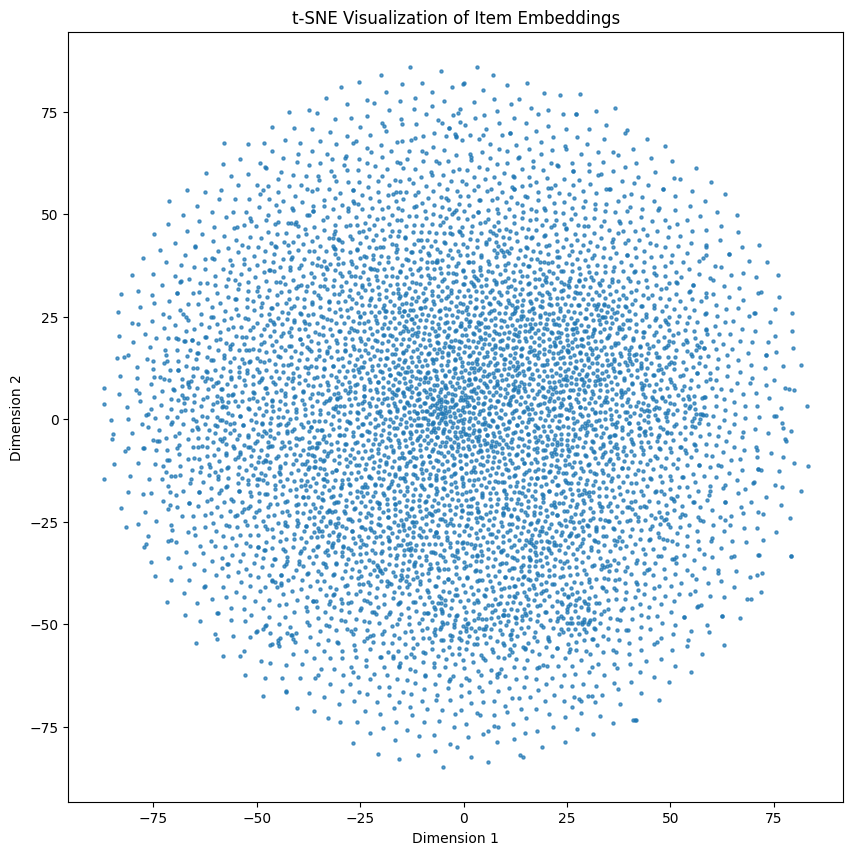

In [1]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from model import noiselocalmamba,usernoiselocalmamba
class Args:
    hidden_units = 128
    maxlen = 256
    dropout_rate = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

# Recreate the model architecture
user_num = 6040 # Replace with actual user count
item_num = 3416  # Replace with actual item count
model = usernoiselocalmamba(user_num, item_num, args, window_size=128).to(args.device)

# Load the saved model
# model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/ml-1m/noiselocalmamba/ml-1m.epoch=500.lr=0.0005.layer=2.head=1.hidden=128.maxlen=256.eval_neg_sample=100_final.pth"
model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/ml-1m/usernoiselocalmamba/ml-1m.epoch=500.lr=0.0005.layer=2.head=1.hidden=128.maxlen=256.eval_neg_sample=100_final.pth"
model.load_state_dict(torch.load(model_path, map_location=args.device))

# Extract item embeddings
# item_embeddings = model.item_emb.weight.detach().cpu().numpy()
user_embeddings = model.user_emb.weight.detach().cpu().numpy()


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
# item_embeddings_2d = tsne.fit_transform(item_embeddings)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))
# plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], s=5, alpha=0.7)
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Item Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from model import noiselocalmamba
class Args:
    hidden_units = 32
    maxlen = 1024
    dropout_rate = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

# Recreate the model architecture
user_num = 26858 # Replace with actual user count
item_num = 32038724  # Replace with actual item count
model = noiselocalmamba(user_num, item_num, args, window_size=128).to(args.device)

# Load the saved model
# model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/ml-1m/noiselocalmamba/ml-1m.epoch=500.lr=0.0005.layer=2.head=1.hidden=128.maxlen=256.eval_neg_sample=100_final.pth"
model_path= "/raid/scratch/gnaneswaras/RecMamba/saved_models/KuaiRand1000/noiselocalmamba/KuaiRand1000.epoch=500.lr=0.0005.layer=2.head=1.hidden=32.maxlen=1024.eval_neg_sample=100_final.pth"
model.load_state_dict(torch.load(model_path, map_location=args.device))

# Extract item embeddings
item_embeddings = model.item_emb.weight.detach().cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
item_embeddings_2d = tsne.fit_transform(item_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of Item Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

2025-05-28 12:29:05.477540: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 12:29:05.529374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-28 12:29:06.460850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Window size for local attention is : 128


2025-05-30 11:18:02.562963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 11:18:02.615836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 11:18:03.655701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Window size for local attention is : 128
User num: 27284, Item num: 32038724


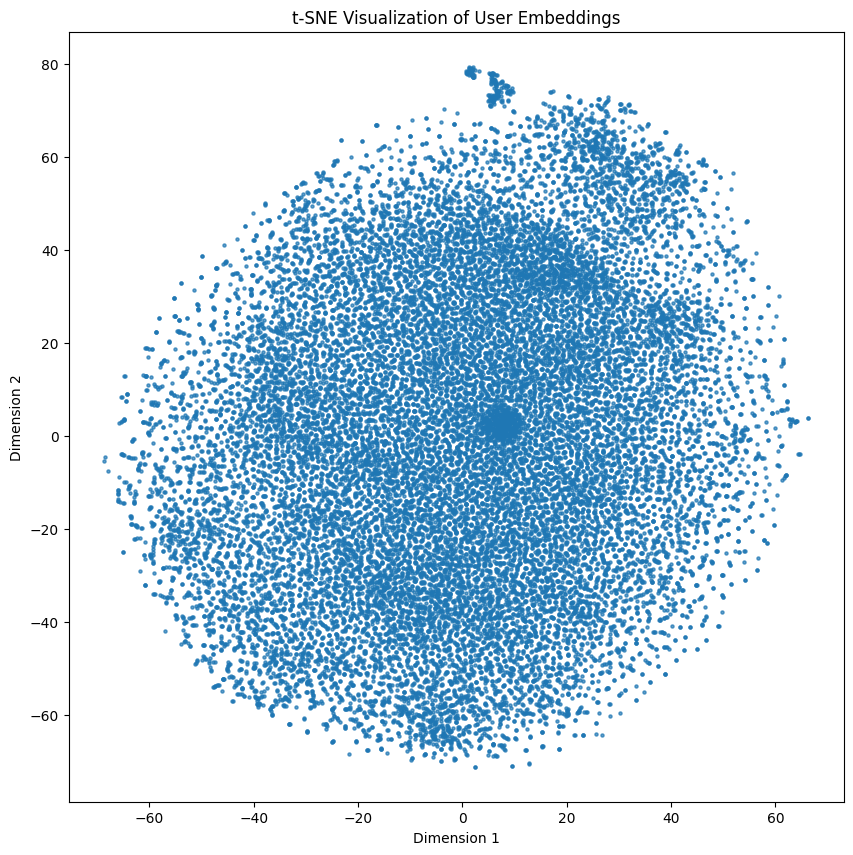

In [1]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from model import noiselocalmamba,usernoiselocalmamba
class Args:
    hidden_units = 32
    maxlen = 1024
    dropout_rate = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

# Recreate the model architecture
user_num = 27284  # From checkpoint
item_num = 32038724  # From checkpoint

model = usernoiselocalmamba(user_num, item_num, args, window_size=128).to(args.device)

# Load the saved model
# model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/ml-1m/noiselocalmamba/ml-1m.epoch=500.lr=0.0005.layer=2.head=1.hidden=128.maxlen=256.eval_neg_sample=100_final.pth"
model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/KuaiRand1000/usernoiselocalmamba/KuaiRand1000.epoch=500.lr=0.0005.layer=2.head=1.hidden=32.maxlen=1024.eval_neg_sample=100_final.pth"
model.load_state_dict(torch.load(model_path, map_location=args.device))

# Extract item embeddings
# item_embeddings = model.item_emb.weight.detach().cpu().numpy()
user_embeddings = model.user_emb.weight.detach().cpu().numpy()


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
# item_embeddings_2d = tsne.fit_transform(item_embeddings)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))
# plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], s=5, alpha=0.7)
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], s=5, alpha=0.7)
plt.title("t-SNE Visualization of User Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [6]:
print(model)
print(user_embeddings.shape)
print(user_embeddings_2d.shape)

usernoiselocalmamba(
  (user_emb): Embedding(27285, 32, padding_idx=0)
  (item_emb): Embedding(32038725, 32, padding_idx=0)
  (pos_emb): Embedding(1024, 32)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (mamba1): Mamba(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (act): SiLU()
    (x_proj): Linear(in_features=64, out_features=66, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (attention_layernorms): ModuleList(
    (0): LayerNorm((32,), eps=1e-08, elementwise_affine=True)
  )
  (attention_layers): ModuleList(
    (0): LocalAttention(
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (forward_layernorms): ModuleList(
    (0): LayerNorm((32,), eps=1e-08, elementwise_affine=True)
  )
  (forward_layers): ModuleList(
    (0): PointWiseFeedForward(
      (conv1): Con

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from model import noiselocalmamba, usernoiselocalmamba

class Args:
    hidden_units = 32
    maxlen = 1024
    dropout_rate = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

# Recreate the model architecture
user_num = 27284  # From checkpoint
item_num = 32038724  # From checkpoint

model = usernoiselocalmamba(user_num, item_num, args, window_size=128).to(args.device)

# Load the saved model
model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/KuaiRand1000/usernoiselocalmamba/KuaiRand1000.epoch=500.lr=0.0005.layer=2.head=1.hidden=32.maxlen=1024.eval_neg_sample=100_final.pth"
model.load_state_dict(torch.load(model_path, map_location=args.device))

# Extract user embeddings
user_embeddings = model.user_emb.weight.detach().cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Calculate density of points


2025-05-31 12:41:20.857502: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 12:41:20.917223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-31 12:41:22.006118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Window size for local attention is : 128
User num: 27284, Item num: 32038724


NameError: name 'np' is not defined

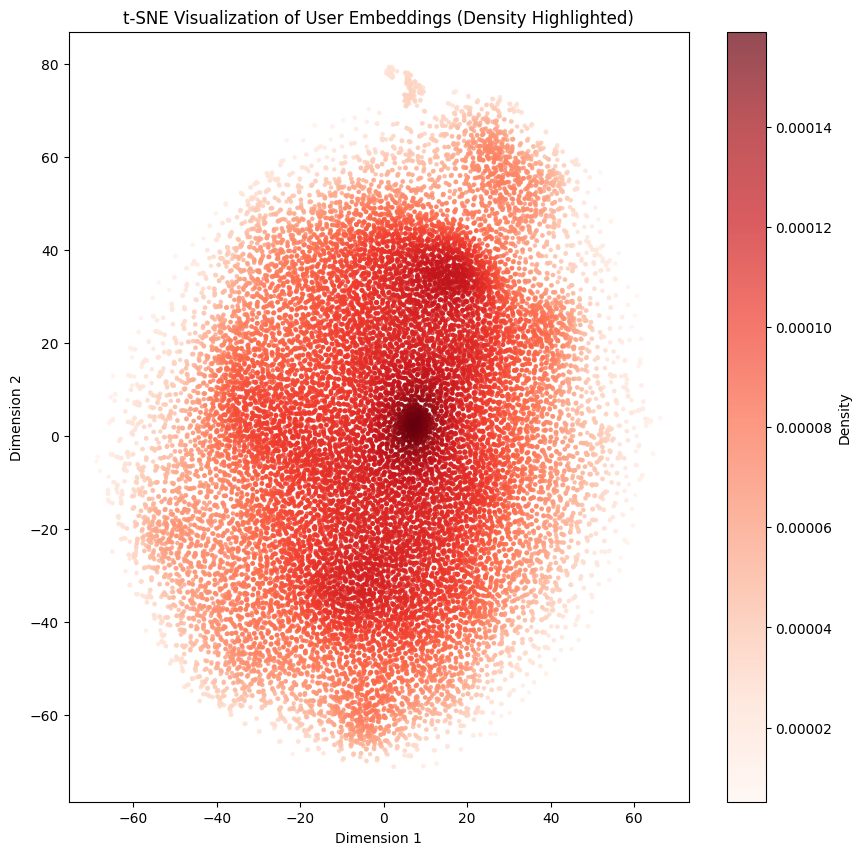

In [3]:
import numpy as np
from scipy.stats import gaussian_kde
x = user_embeddings_2d[:, 0]
y = user_embeddings_2d[:, 1]
xy = np.vstack([x, y])
density = gaussian_kde(xy)(xy)

# Plot the embeddings with density-based coloring
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=density, cmap='Reds', s=5, alpha=0.7)
plt.colorbar(label="Density")
plt.title("t-SNE Visualization of User Embeddings (Density Highlighted)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Window size for local attention is : 128
User num: 27284, Item num: 32038724


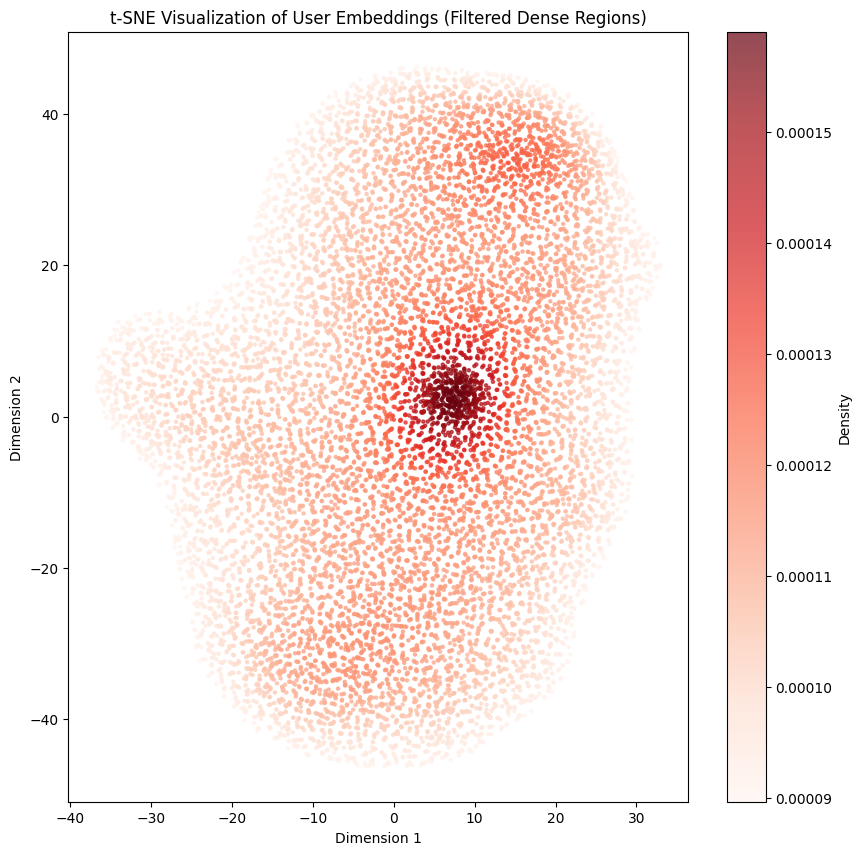

In [4]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from model import noiselocalmamba, usernoiselocalmamba

class Args:
    hidden_units = 32
    maxlen = 1024
    dropout_rate = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

# Recreate the model architecture
user_num = 27284  # From checkpoint
item_num = 32038724  # From checkpoint

model = usernoiselocalmamba(user_num, item_num, args, window_size=128).to(args.device)

# Load the saved model
model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/KuaiRand1000/usernoiselocalmamba/KuaiRand1000.epoch=500.lr=0.0005.layer=2.head=1.hidden=32.maxlen=1024.eval_neg_sample=100_final.pth"
model.load_state_dict(torch.load(model_path, map_location=args.device))

# Extract user embeddings
user_embeddings = model.user_emb.weight.detach().cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Calculate density of points
x = user_embeddings_2d[:, 0]
y = user_embeddings_2d[:, 1]
xy = np.vstack([x, y])
density = gaussian_kde(xy)(xy)

# Filter points based on density threshold
density_threshold = np.percentile(density, 50)  # Keep only the top 50% dense points
mask = density > density_threshold
x_filtered = x[mask]
y_filtered = y[mask]
density_filtered = density[mask]

# Plot the filtered embeddings with density-based coloring
plt.figure(figsize=(10, 10))
plt.scatter(x_filtered, y_filtered, c=density_filtered, cmap='Reds', s=5, alpha=0.7)
plt.colorbar(label="Density")
plt.title("t-SNE Visualization of User Embeddings (Filtered Dense Regions)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Window size for local attention is : 128
User num: 27284, Item num: 32038724


/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


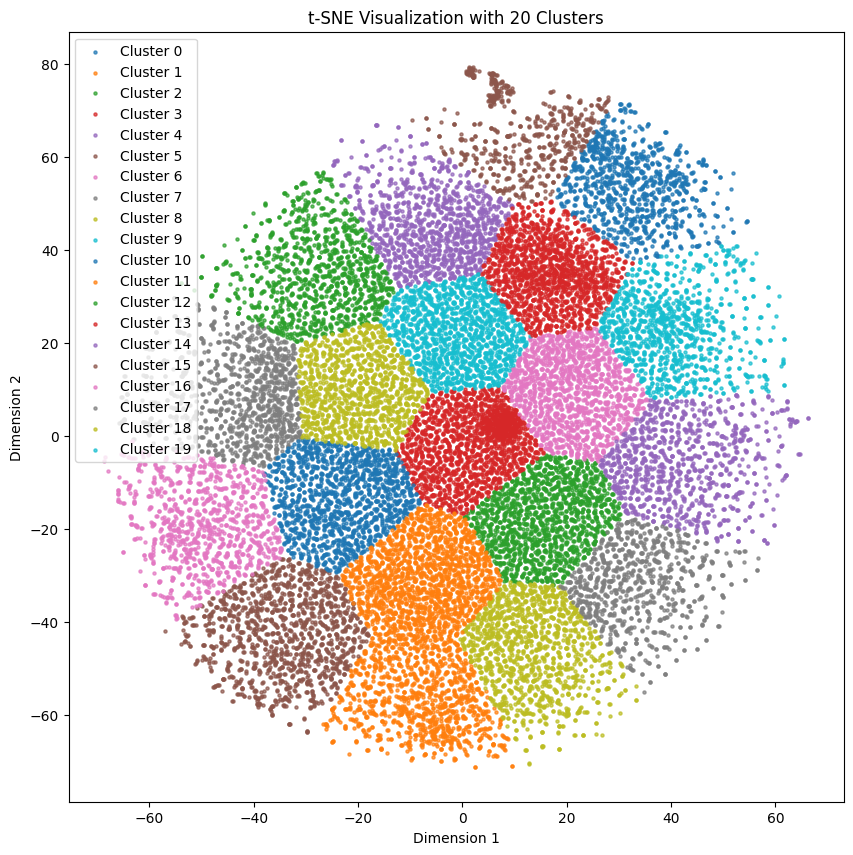

In [5]:
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from model import noiselocalmamba, usernoiselocalmamba

class Args:
    hidden_units = 32
    maxlen = 1024
    dropout_rate = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

# Recreate the model architecture
user_num = 27284  # From checkpoint
item_num = 32038724  # From checkpoint

model = usernoiselocalmamba(user_num, item_num, args, window_size=128).to(args.device)

# Load the saved model
model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/KuaiRand1000/usernoiselocalmamba/KuaiRand1000.epoch=500.lr=0.0005.layer=2.head=1.hidden=32.maxlen=1024.eval_neg_sample=100_final.pth"
model.load_state_dict(torch.load(model_path, map_location=args.device))

# Extract user embeddings
user_embeddings = model.user_emb.weight.detach().cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Apply K-Means clustering to form 20 clusters
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(user_embeddings_2d)

# Plot the t-SNE results with cluster coloring
plt.figure(figsize=(10, 10))
for cluster_id in range(20):
    cluster_points = user_embeddings_2d[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=5, alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization with 20 Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

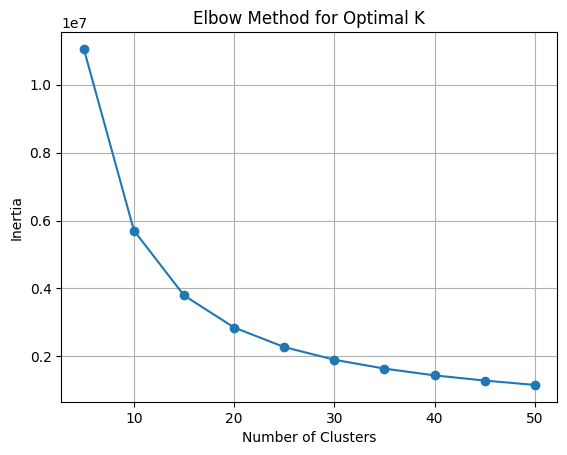

In [6]:
inertias = []
cluster_range = range(5, 51, 5)
for k in cluster_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(user_embeddings_2d)  # or reduced PCA embeddings
    inertias.append(km.inertia_)

plt.plot(cluster_range, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


2025-05-31 17:44:49.222347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 17:44:49.272566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-31 17:44:50.246141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Window size for local attention is : 128
User num: 27284, Item num: 32038724


/raid/home/gnaneswaras/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


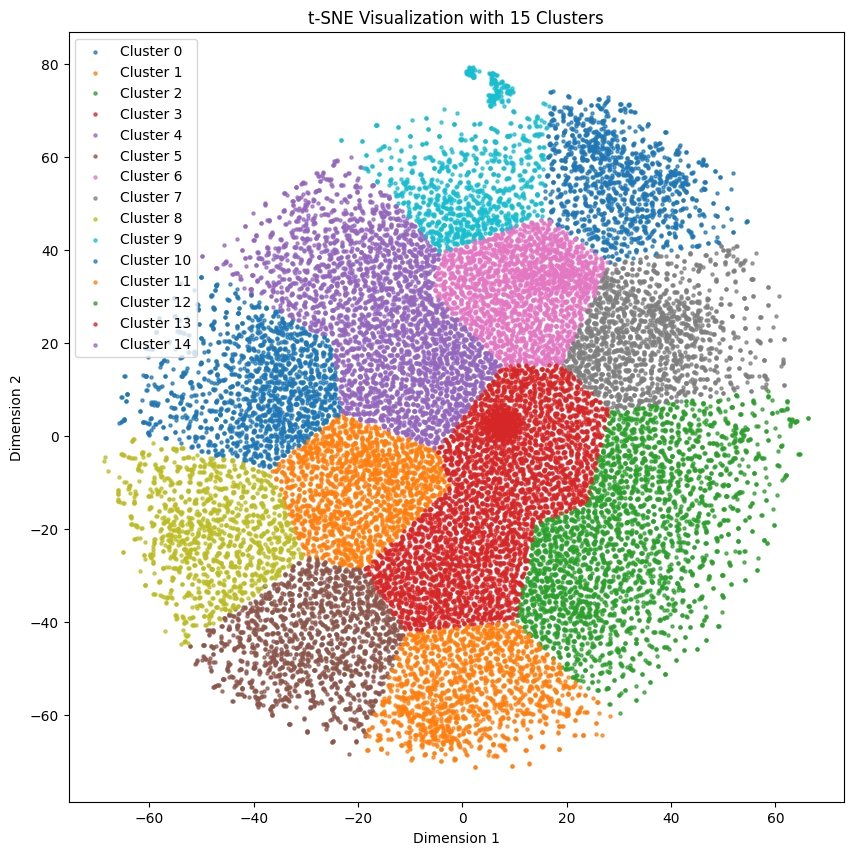

In [1]:
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from model import noiselocalmamba, usernoiselocalmamba

class Args:
    hidden_units = 32
    maxlen = 1024
    dropout_rate = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

# Recreate the model architecture
user_num = 27284  # From checkpoint
item_num = 32038724  # From checkpoint

model = usernoiselocalmamba(user_num, item_num, args, window_size=128).to(args.device)

# Load the saved model
model_path = "/raid/scratch/gnaneswaras/RecMamba/saved_models/KuaiRand1000/usernoiselocalmamba/KuaiRand1000.epoch=500.lr=0.0005.layer=2.head=1.hidden=32.maxlen=1024.eval_neg_sample=100_final.pth"
model.load_state_dict(torch.load(model_path, map_location=args.device))

# Extract user embeddings
user_embeddings = model.user_emb.weight.detach().cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Apply K-Means clustering to form 20 clusters
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(user_embeddings_2d)

# Plot the t-SNE results with cluster coloring
plt.figure(figsize=(10, 10))
for cluster_id in range(15):
    cluster_points = user_embeddings_2d[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=5, alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization with 15 Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()